<a href="https://colab.research.google.com/github/Nahmadid/sbinn/blob/main/pkpd_hybrid_normalized_moving_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exprement 1**

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
import jax.nn as jnn
import pandas as pd
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

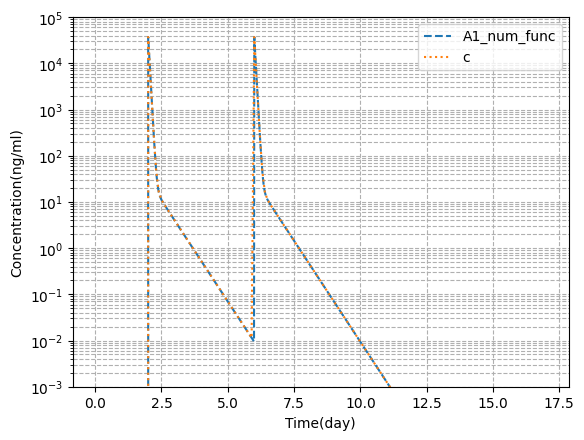

In [21]:
import jax.numpy as jnp
from scipy.interpolate import interp1d


k10 = 0.868*24
k12 = 0.006*24
k21 = 0.0838*24

V1 = 810


def simulate_system(dose_times, num=1700, dt=0.01, k10=0.868*24, k12=0.006*24, k21=0.0838*24):
    A1 = []
    A2 = []
    A1.append(0)  # Initial condition for A1
    A2.append(0)  # Initial condition for A2

    # dose_times = [13, 17, 21]

    for i in range(1, num + 1):
        product = i * dt
        if product.is_integer() and int(product) in dose_times:
            mu = 3e+7
        else:
            mu = 0

        A1i = A1[i-1] - dt * (k10 + k12) * A1[i-1] + dt * k21 * A2[i-1] + mu
        A2i = A2[i-1] + dt * k12 * A1[i-1] - dt * k21 * A2[i-1]
        A1.append(A1i)
        A2.append(A2i)

    return jnp.array(A1)#, jnp.array(A2)
# dose_times = [13, 17, 21]
dose_times = [2, 6]
# A1, A2 = simulate_system()
A1 = simulate_system(dose_times)

t_c = jnp.linspace(0, 17, 171)[:, None]
t_dense = jnp.linspace(0, 17, 1701)
c = jnp.interp(t_c, t_dense, A1)/V1

t = np.linspace(0, 35, 3501)
# plt.plot(t, Cb_num/V1, label='C_num')
# plt.plot(t, Qm/V1, '--', label='C_eq')
plt.plot(t_dense, A1/V1, '--', label='A1_num_func')
plt.plot(t_c, c, ':', label='c')
# plt.plot(t, Qm2_debug/V1, ':', label='C2_eq')
# plt.plot(t, Qm2/V1, '--', label='C_eq')


plt.xlabel("Time(day)")
plt.ylabel("Concentration(ng/ml)")
plt.yscale('log')
plt.ylim(0.001, 100000 )
# plt.xlim(7, 20 )
# plt.ylim(10, 100000)
# plt.xlim(12, 29)
plt.grid()
plt.legend()
plt.grid(True,which="both", ls="--")
plt.xscale('linear')
# print((Cb_num/V1))#().reshape(-1,1))#



In [76]:
def normalize(x):
  x_min = jnp.min(x)
  x_max = jnp.max(x)
  x_scaled = (x - x_min)/(x_max - x_min)
  return x_scaled

def denormalize(x_scaled, y_dense):
  x_min = jnp.min(y_dense)
  x_max = jnp.max(y_dense)
  x= x_scaled*(x_max - x_min)+ x_min
  return x

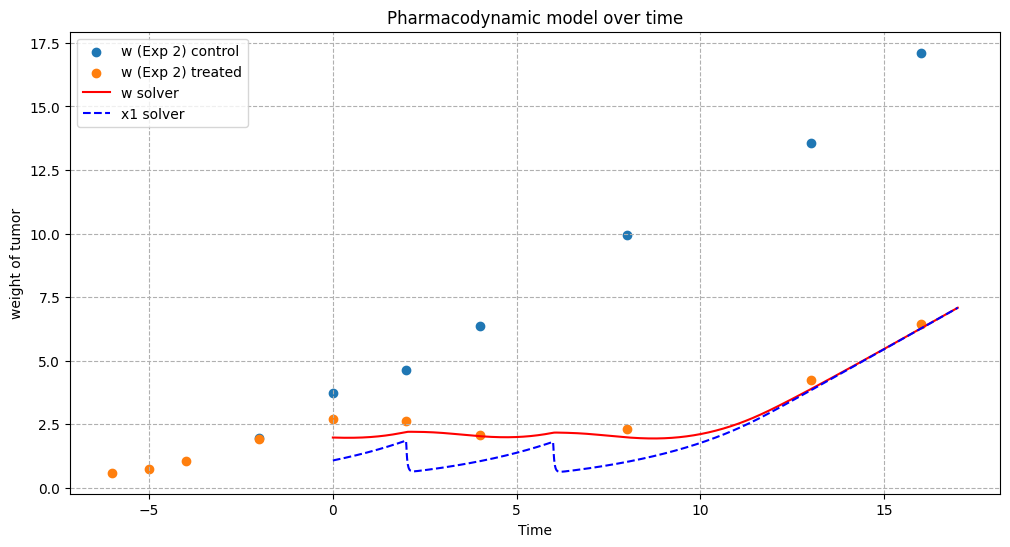

(array([2.72, 2.64, 2.08, 2.32, 4.24, 6.44]),
 array([ 0,  2,  4,  8, 13, 16]),
 array([0.0689802 , 0.16771737, 0.6994229 , 0.85285485], dtype=float32))

In [90]:
#@title jax implementation
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from jax.experimental.ode import odeint as jax_odeint



#Expriment 1 , day 8-12-16
# psi = 20
# k1 = 0.968 #==> True
# k2 = 6.29e-4 #==> True
# lambda_0_exp1 =0.311#0.273 #0.311#*24 #==> True
# lambda_1_exp1 = 0.656#0.814#0.656#*24 #==> True
# w0_exp1 = 0.033
V1 = 810

# #Expriment 2 , day 13 - 17 - 21
psi = 20
k1 = 0.968#==> True
k2 = 6.29e-4 #==> True
lambda_0_exp1 =0.273 #0.311#*24 #==> True
lambda_1_exp1 = 0.814#0.656#*24 #==> True
w0_exp1 = 0.055 #==> not true 0.055
w0_exp1 = 2.72 #==> not true 0.055




# Defining the model
def pd(t, w0=w0_exp1, lambda_0=lambda_0_exp1, lambda_1=lambda_1_exp1, k1=k1, k2=k2):
    def func(y, t):
        # t_dose=np.arange(8,17,4)
        # t_dose=np.arange(13,22,4)

        # A = 29975901.2365281
        # B = 24098.7619595
        # kA = 20.9912588
        # kB = 1.9959407

        # Qm = np.sum([
        #     A * np.exp(-kA * (t - t_d))*np.heaviside(t - t_d, 0.001) + B * np.exp(-kB * (t - t_d))*np.heaviside(t - t_d, 0.001)
        #     for t_d in t_dose
        # ], axis=0)
        # c = Qm/V1
        dose_times = [17-15, 21-15]
        A1 = simulate_system(dose_times)
        t_dense = jnp.linspace(0, 17, 1701)
        c = jnp.interp(t, t_dense, A1)/V1
        # c = A1.reshape(-1,1)/V1
        # c = 0
        #########################
        x1, x2, x3, x4 = y
        w = x1 + x2 + x3 + x4


        dx1_dt = lambda_0 * x1 * (1 + (lambda_0 / lambda_1 * w)**(psi))** (-1/psi) - k2 *c* x1
        dx2_dt = k2 *c* x1 - k1 * x2
        dx3_dt = k1 * (x2 - x3)
        dx4_dt = k1 * (x3 - x4)
        # dx5_dt = k1 * (x4 - x5)
        return [dx1_dt, dx2_dt, dx3_dt, dx4_dt]

    # Initial conditions
    y0 = jnp.array([1.082, 0.191, 0.36, 0.35], dtype=jnp.float32)
    return jax_odeint(func, y0, t)



# scale_factor = jnp.array([20, 2, 2, 2])
# Time points
t_dense = jnp.linspace(0, 17, 1701)  # Assuming 10 time units, change as necessary

# Run model for experiment 1
y_dense = pd(jnp.ravel(t_dense))# /scale_factor


# y_dense = (y_dense - min_values) / (max_values - min_values)

# y_dense = pd(t_dense)/scale_factor
# Plotting
w= y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
# w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]

plt.figure(figsize=(12, 6))

t_label2 = np.array([9, 10, 11, 13, 15, 17, 19, 23, 28, 31])
w_real2 = np.array([0.6, 0.76, 1.08, 1.92, 2.72, 2.64, 2.08, 2.32, 4.24, 6.44])

t_control = np.array([10, 11, 12, 14, 15, 16, 17, 18, 19 , 20, 22, 24, 35])
w_control = np.array([0.75, 1.07, 1.47, 2.49, 3.3, 3.67, 4.44, 4.96, 5.85, 6.47, 7.84, 9.24, 17.65])

t_control2 = np.array([ 13, 15, 17, 19, 23, 28, 31])
w_control2 = np.array([ 1.96, 3.75, 4.65, 6.36, 9.93, 13.58, 17.11])

t_label1 = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 27]
w_real1 = [0.35, 0.51, 0.43, 0.47, 0.39, 0.43, 0.55, 0.63, 0.74, 0.82, 0.94, 1.10, 1.49, 2.27, 3.29]


# plt.scatter(t_label1, w_real1, label='w (Exp 1) measured')
# plt.scatter(t_control, w_control, label='w (Exp 1) control')
plt.scatter(t_control2-15, w_control2, label='w (Exp 2) control')
plt.scatter(t_label2-15, w_real2, label='w (Exp 2) treated')
plt.plot(t_dense, w, '-',color='red', label='w solver')
plt.plot(t_dense, y_dense[:, 0], '--b', label='x1 solver')
# plt.plot(t_dense, C1(t_den/se), '-', label='c1 solver')
# plt.plot(t_dense, y_dense[:, 1], '--r', label='x2 solver')
# plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
# plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
# plt.ylim(0, 18)
plt.title('Pharmacodynamic model over time')
plt.xlabel('Time')
plt.ylabel('weight of tumor')
plt.legend()
plt.grid(True,which="both", ls="--")
plt.xscale('linear')
# plt.grid(which="both")
plt.show()

t_i  = jnp.array([[0]])
# IC = np.array([y_dense[:, 0][0],0,0, 0])
i1 = normalize(y_dense[:, [0]])
i2 = normalize(y_dense[:, [1]])
i3 = normalize(y_dense[:, [2]])
i4 = normalize(y_dense[:, [3]])
# IC = np.array([1.082, 0.191, 0.36, 0.35])
IC = np.array([i1[0], i2[0], i3[0], i4[0]])
IC = np.array(IC).astype(np.float32).flatten()

t_data = t_label2[4:]-15
# data = y_dense[::sample_rate]
# w = data[:, 0] + data[:, 1]+ data[:, 2]+ data[:, 3]
data = w_real2[4:]

# data = jnp.concatenate([Ip_data, Ii_data, G_data, h1_data, h2_data, h3_data], axis=1)
data, t_data , IC


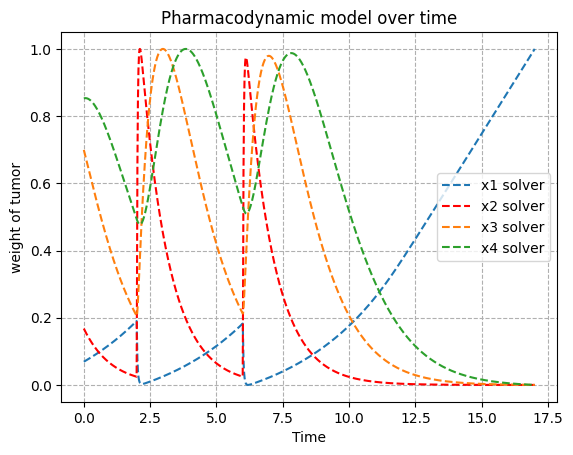

In [91]:
plt.plot(t_dense, normalize(y_dense[:, [0]]), '--', label='x1 solver')
# plt.plot(t_dense, y_scaled[:, [0]], '--', label='x1 scaled')
# plt.plot(t_dense, y_dense[:, 0], 'r--', label='x1 solver')
plt.plot(t_dense, normalize(y_dense[:, [1]]), '--r', label='x2 solver')
# plt.plot(t_dense, y_scaled[:, [1]], '--', label='x2 scaled')
plt.plot(t_dense, normalize(y_dense[:, [2]]), '--', label='x3 solver')
plt.plot(t_dense, normalize(y_dense[:, [3]]), '--', label='x4 solver')
# plt.ylim(0, 18)
plt.title('Pharmacodynamic model over time')
plt.xlabel('Time')
plt.ylabel('weight of tumor')
plt.legend()
plt.grid(True,which="both", ls="--")
plt.xscale('linear')
# plt.grid(which="both")
plt.show()

#**PINNs**

In [92]:
############################################
# tmin,tmax=0.

t_dense = np.linspace(0, 35, 3501)[:, None]
tmin, tmax = t_dense[0,0], t_dense[-1,0]

def softmax(x):
    e_x = jnp.exp(x - jnp.max(x))  # Use jnp instead of np
    return e_x / e_x.sum(axis=0)

def xavier_init(size, seed=None):
    key = jax.random.PRNGKey(seed) if seed is not None else jax.random.PRNGKey(0)
    in_dim, out_dim = size
    xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
    return jax.random.truncated_normal(key, shape=(in_dim, out_dim), dtype=jnp.float32, stddev=xavier_stddev)


def init_params(layers, seed):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        # Xavier initialization for weights using normal distribution
        xavier_stddev = jnp.sqrt(2.0 / (n_in + n_out))
        W = jax.random.normal(key, shape=(n_in, n_out)) * xavier_stddev  # Scale by Xavier stddev

        # Bias initialized to zero
        B = jnp.zeros((n_out,))

        # Append parameters with additional constants k1 and k2 if needed
        params.append({'W': W, 'B': B, 'k1': 0.1, 'k2': 0.1})

    return params

def feature_transform(t):
    t = 0.1 * t
    return jnp.concatenate(
        (t, jnp.exp(t), jnp.exp(2 * t), jnp.exp(3 * t), jnp.exp(4 * t)),
        axis=1,
    )



def output_transform(t, y, y_dense, t_dense):
    idx = 3500
    k = (y_dense[idx] - y_dense[0]) / (t_dense[idx] - t_dense[0])
    b = (t_dense[idx] * y_dense[0] - t_dense[0] * y_dense[idx]) / (
            t_dense[idx] - t_dense[0])
    linear = k * t*100 + b
    factor = 1  # jnp.tanh(t) * jnp.tanh(idx - t)

    return linear + factor * y




def fwd(params, t):
    t = t/10
    X = jnp.concatenate([t],axis=0)
    # X = feature_transform(t)  # Apply the feature_transform to input t
    inputs= X
    *hidden, last = params
    for layer in hidden:
        inputs = jax.nn.tanh(inputs @ layer['W'] + layer['B'])

    # Y= jax.nn.swish(inputs @ last['W'] + last['B'])
    Y= inputs @ last['W'] + last['B']
    Y=jnn.softplus(Y)
    # Y= np.log(Y)
    # Y= output_transform(t, Y, y_dense, t_dense)
    return Y

# def fwd_extra(params,t):
#   # t = 0.01 * t
#   X = jnp.concatenate([t],axis=0)
#   *hidden,last = params
#   for layer in hidden :
#     X = jax.nn.tanh(X@layer['W']+layer['B'])
#   X = X@last['W'] + last['B']
#   return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)

def L1_relative_error(true, pred):
    return jnp.mean(jnp.abs((true - pred) / true))


def L1_error(true, pred):
    return jnp.mean(jnp.abs(true - pred))


def L2_error(true, pred):
    return jnp.sqrt(jnp.mean((true - pred) ** 2))


def L2_relative_error(true, pred):
    return jnp.sqrt(jnp.mean(((true - pred) / true) ** 2))


def L2_relative_error(true, pred, eps=1e-8):
    return jnp.sqrt(jnp.mean(((true - pred) / (true + eps)) ** 2))


def jax_interp(t, y):
    t_dense = np.linspace(0, 35, 3501)
    # y_dense = pd(t_dense)
    return jnp.interp(t, t_dense, y)


In [ ]:
np.arange(2,7,4)

array([2, 6])

In [107]:
################################################
def ODE_loss(t, y1, y2, y3, y4, y1_sol, y2_sol, y3_sol, y4_sol, params):
    psi = 20
    k1 = 0.968#==> True
    k2 = 6.29e-4 #==> True
    l0 =0.273 #0.311#*24 #==> True
    l1 = 0.814#0.656#*24 #==> True
    w0_exp1 = 0.055 #==> not true 0.055

    # # # k1 = get_variable(1, params[0]['k12'])
    # k1 = jnp.tanh(params[0]['k1']) * 0.6 + 1.0
    # k2 = (jnp.tanh(params[0]['k2']) * 5*1e-4 + 10*1e-4)
    # t_dose=np.arange(13,22,4)

    # t_dose=np.arange(13,22,4)
    t_dose=np.arange(2,7,4)
    # tc = np.linspace(0, 17, 171)[:, None]
    # A = 29975901.2365281
    # B = 24098.7619595
    # kA = 20.9912588
    # kB = 1.9959407

    # Qm = np.sum([
    # A * np.exp(-kA * (tc - t_d))*np.heaviside(tc - t_d, 0.001) + B * np.exp(-kB * (tc - t_d))*np.heaviside(tc - t_d, 0.001)
    # for t_d in t_dose
    # ], axis=0)
    # c = Qm/V1
    # c= jnp.array(c)
    # # # # c=0
    A1 = simulate_system(t_dose)
    t_dense = jnp.linspace(0,17 , 1701)
    c = jnp.interp(t, t_dense, A1)/V1
    c = c.reshape(-1,1)


    y_1= denormalize(y1(t),y_dense[:,[0]])
    y_2= denormalize(y2(t),y_dense[:,[1]])
    y_3= denormalize(y3(t),y_dense[:,[2]])
    y_4= denormalize(y4(t),y_dense[:,[3]])

    # y_1s= y1_sol(t) *scale_factor[0]
    # y_2s= y2_sol(t) *scale_factor[1]
    # y_3s= y3_sol(t) *scale_factor[2]
    # y_4s= y4_sol(t) *scale_factor[3]

    # y_4= y4(jnp.reshape(t, (-1, 1))) *scale_factor[3]

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    y4_t = lambda t: jax.grad(lambda t: jnp.sum(y4(t)))(t)


    x1, x2, x3, x4 = y_1, y_2, y_3, y_4
    w = x1 + x2 + x3 + x4

    x1_scale= jnp.max(y_dense[:,[0]]) - (jnp.min(y_dense[:,[0]]))
    x2_scale= jnp.max(y_dense[:,[1]]) - (jnp.min(y_dense[:,[1]]))
    x3_scale= jnp.max(y_dense[:,[2]]) - (jnp.min(y_dense[:,[2]]))
    x4_scale= jnp.max(y_dense[:,[3]]) - (jnp.min(y_dense[:,[3]]))


    # ode1 = y1_t(t) - 1/scale_factor[0]*((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    # ode2 = y2_t(t) - 1/scale_factor[1]*((k2 *c* x1 - k1 * x2))
    # ode3 = y3_t(t) - 1/scale_factor[2]*((k1 * (x2 - x3)))
    # ode4 = y4_t(t) - 1/scale_factor[3]*((k1 * (x3 - x4)))


    ode1 = x1_scale * y1_t(t) - ((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    ode2 = x2_scale * y2_t(t) - ((k2 *c* x1 - k1 * x2))
    ode3 = x3_scale * y3_t(t) - ((k1 * (x2 - x3)))
    ode4 = x4_scale * y4_t(t) - ((k1 * (x3 - x4)))

    return ode1, ode2, ode3, ode4




#collocation points
# N_c = 350

t_c = jnp.linspace(0, 17, 171)[:, None]

# def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):
def loss_fun(params, t_i, t_d, t_c, data_IC, data):

    # l3, l4 = 1, 1
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    y4_func = lambda t: fwd(params, t)[:, [3]]
    # ft      = lambda t: fwd(params, t)[:, [4]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    # y2_func = interp1d(t_dense.flatten(), y_dense[:, 1], kind='linear', fill_value='extrapolate')
    # y3_func = interp1d(t_dense.flatten(), y_dense[:, 2], kind='linear', fill_value='extrapolate')
    # y4_func = interp1d(t_dense.flatten(), y_dense[:, 3], kind='linear', fill_value='extrapolate')
    # t_dense = np.linspace(0, 35, 3501)
    y1_func_sol = lambda t:jax_interp(t, y_dense[:, 0])
    y2_func_sol = lambda t:jax_interp(t, y_dense[:, 1])
    y3_func_sol = lambda t:jax_interp(t, y_dense[:, 2])
    y4_func_sol = lambda t:jax_interp(t, y_dense[:, 3])

    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    # loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func, y4_func,params)
    loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func,y4_func,y1_func_sol, y2_func_sol, y3_func_sol, y4_func_sol, params)

    # loss_y1 = l1*loss_y1
    # loss_y2 = l2*loss_y2
    # loss_y3 = l3*loss_y3
    # loss_y4 = l4*loss_y4

    loss_y1 = loss_y1
    loss_y2 = loss_y2
    loss_y3 = loss_y3
    loss_y4 = loss_y4

    # loss_ode1 = jnp.mean(loss_y1 ** 2)
    # loss_ode2 = jnp.mean(loss_y2 ** 2)
    # loss_ode3 = jnp.mean(loss_y3 ** 2)
    # loss_ode4 = jnp.mean(loss_y4 ** 2)


    loss_ode1 = jnp.sqrt(jnp.mean((loss_y1) ** 2))#/jnp.max(loss_y1)
    loss_ode2 = jnp.sqrt(jnp.mean((loss_y2) ** 2))#/jnp.max(loss_y2)
    loss_ode3 = jnp.sqrt(jnp.mean((loss_y3) ** 2))#/jnp.max(loss_y3)
    loss_ode4 = jnp.sqrt(jnp.mean((loss_y4) ** 2))#/jnp.max(loss_y4)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    # i= np.array([0]).reshape(-1,1)
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i),y3_func(t_i), y4_func(t_i)],axis=1)
    # loss_IC = MSE(data_IC, pred_IC)
    loss_IC = L2_error(data_IC, pred_IC)



    # t_d    = t_d.flatten()[:,None]
    # w = denormalize(y1_func(t_d), y_dense[:,[0]]) + denormalize(y2_func(t_d), y_dense[:,[1]]) + denormalize(y3_func(t_d), y_dense[:,[2]])+ denormalize(y4_func(t_d), y_dense[:,[3]])
    # data = data.reshape(-1, 1)
    # # pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    # loss_data = MSE(data, w)
    loss_data = 0



    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4





# def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

#     return loss_total


def loss_fun_total(params, t_i, t_d, t_c, data_IC, data, loss_weight):

    # loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)
    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

    return loss_total


@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0])(params, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state, params



# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

#   #Update params
#   updates, opt_state = optimizer.update(grads[0], opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
#   params_l1 = optax.apply_updates(params_l1, updates_l1)

#   updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
#   params_l2 = optax.apply_updates(params_l2, updates_l2)


#   return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2






#################################################################
num_seeds = 1

all_C1 = []
# all_C2 = []
# all_k = []
k2_values_list = []
k1_values_list = []
l1_values_list = []
l2_values_list = []

loss_his, loss_indi_his, epoch_his = [], [], []
# start_time = time.time()
epochs_phase1 = 0#5000#10000
epochs_phase2 = 70000#1000
# loss_weight_phase1 = [1, 1, 1, 1, 1, 1]
loss_weight_phase1 = [1, 1, 0, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]

for sd in range(num_seeds):
    print(f"traning for seed number {sd} : ")
    seed = 123#random.randint(1, 1000)
    params = init_params([1] + [30]*6+[4], seed)
    # params_extra = init_params([1] + [20]*4+[1],seed)  # Initialize parameters for the extra neural network

    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)
    # optimizer_ex = optax.adam(1e-3)
    # opt_state_extra = optimizer_ex.init(params_extra)


    # keys = jax.random.split(jax.random.PRNGKey(seed), 10)
    # lambda_p = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
    # lambda_1 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
    # lambda_2 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
    # lambda_3 = jax.random.uniform(keys[3], shape=(N_c + 1, 1))


    # opt_state_lp = optimizer.init(lambda_p)
    # opt_state_l1 = optimizer.init(lambda_1)
    # opt_state_l2 = optimizer.init(lambda_2)
    # opt_state_l3 = optimizer.init(lambda_3)

    for ep in range(epochs_phase1 + epochs_phase2 + 1):
        if ep <= epochs_phase1:
            loss_weight = loss_weight_phase1
        else:
            loss_weight = loss_weight_phase2

        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight)

        # print loss and epoch info
        if ep %(1000) ==0:
          loss_val = loss_fun_total(params, t_i, t_data, t_c, IC, data, loss_weight)
          loss_val_individual = loss_fun(params, t_i, t_data, t_c, IC, data)
          epoch_his.append(ep)
          loss_his.append(loss_val)
          loss_indi_his.append(loss_val_individual)

        if ep %(1000) ==0:
          print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e},\t loss_e3={loss_val_individual[4]:.2e},\t loss_e4={loss_val_individual[5]:.2e}')

          # k1_out = jnp.tanh(params[0]['k1']) * 0.6 + 1.0
          # k2_out = (jnp.tanh(params[0]['k2']) * 5*1e-4 + 10*1e-4)
          # print(f"k1 = {k1_out}, k2 = {k2_out:.4e}")

    np.savez(f'./params_{sd}.npz', *params)



traning for seed number 0 : 
Epoch=0, 	 , 	 loss=4.15e-01, 	 loss_IC=4.15e-01, 	 loss_d=0.00e+00, 	 loss_e1=1.52e+00,	 loss_e2=1.69e+00,	 loss_e3=6.11e-01,	 loss_e4=1.61e-01
Epoch=1000, 	 , 	 loss=5.79e-01, 	 loss_IC=3.14e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.69e-01,	 loss_e2=2.50e-01,	 loss_e3=1.50e-02,	 loss_e4=1.41e-02
Epoch=2000, 	 , 	 loss=5.07e-01, 	 loss_IC=2.70e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.59e-01,	 loss_e2=2.10e-01,	 loss_e3=4.15e-04,	 loss_e4=1.04e-02
Epoch=3000, 	 , 	 loss=4.88e-01, 	 loss_IC=2.80e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.55e-01,	 loss_e2=2.02e-01,	 loss_e3=3.16e-04,	 loss_e4=3.01e-03
Epoch=4000, 	 , 	 loss=4.83e-01, 	 loss_IC=2.94e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.53e-01,	 loss_e2=1.99e-01,	 loss_e3=2.64e-04,	 loss_e4=9.08e-04
Epoch=5000, 	 , 	 loss=4.80e-01, 	 loss_IC=3.06e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.51e-01,	 loss_e2=1.98e-01,	 loss_e3=8.02e-05,	 loss_e4=2.28e-04
Epoch=6000, 	 , 	 loss=4.80e-01, 	 loss_IC=3.11e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.51

KeyboardInterrupt: 

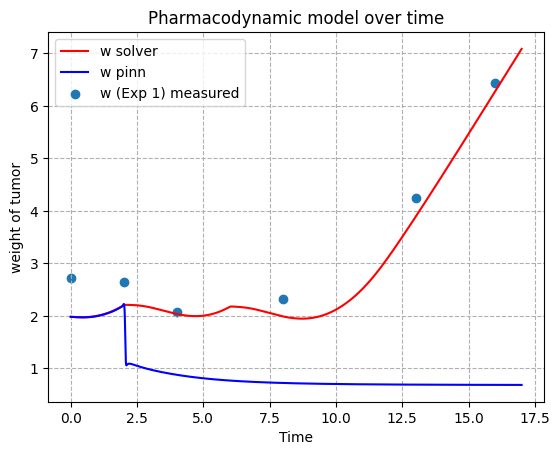

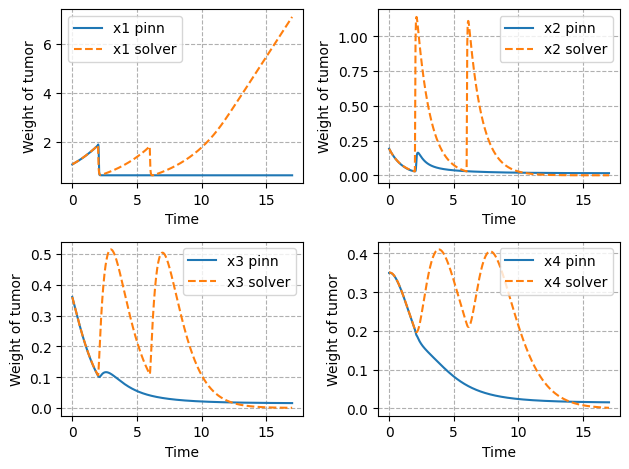

In [109]:
#@title 6100 iteration without data
t_dense = np.linspace(0, 17, 1701)[:, None]
pred = fwd(params,t_dense)

# C = pred[:,0]*scale_factor[0]+y_dense[:,1]*scale_factor[1]+ y_dense[:,2]*scale_factor[2]+y_dense[:,3]*scale_factor[3]
w = y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
C = denormalize(pred[:,[0]], y_dense[:,[0]]) + denormalize(pred[:,[1]], y_dense[:,[1]]) + denormalize(pred[:,[2]], y_dense[:,[2]])+ denormalize(pred[:,[3]], y_dense[:,[3]])
plt.figure()
# w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]
plt.plot(t_dense, w, '-',color='red', label='w solver')
plt.plot(t_dense, C, '-',color='blue', label='w pinn')
plt.scatter(t_data, data, label='w (Exp 1) measured')


plt.title('Pharmacodynamic model over time')
plt.xlabel('Time')
plt.ylabel('weight of tumor')
plt.legend()
plt.grid(True,which="both", ls="--")
plt.xscale('linear')
# plt.grid(which="both")
plt.show()





# Assuming 'pred', 'y_dense', and 'scale_factor' are defined
t_dense = np.linspace(0, 17, 1701)[:, None]

# plt.figure(figsize=(10, 10))  # You can adjust the figure size to better fit your display

# First subplot
plt.subplot(2, 2, 1)
plt.plot(t_dense, denormalize(pred[:,[0]], y_dense[:,[0]]), '-', label='x1 pinn')
plt.plot(t_dense, y_dense[:, 0], '--', label='x1 solver')
# plt.title('Pharmacodynamic model over time - x1')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Second subplot
plt.subplot(2, 2, 2)
plt.plot(t_dense, denormalize(pred[:,[1]], y_dense[:,[1]]), '-', label='x2 pinn')
plt.plot(t_dense, y_dense[:, 1], '--', label='x2 solver')
# plt.title('Pharmacodynamic model over time - x2')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Third subplot
plt.subplot(2, 2, 3)
plt.plot(t_dense, denormalize(pred[:,[2]], y_dense[:,[2]]), '-', label='x3 pinn')
plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
# plt.title('Pharmacodynamic model over time - x3')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Fourth subplot
plt.subplot(2, 2, 4)
plt.plot(t_dense, denormalize(pred[:,[3]], y_dense[:,[3]]), '-', label='x4 pinn')
plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
# plt.title('Pharmacodynamic model over time - x4')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()


#**forward without data moving window**

In [126]:
################################################
def ODE_loss(t, y1, y2, y3, y4, y1_sol, y2_sol, y3_sol, y4_sol, params):
    psi = 20
    k1 = 0.968#==> True
    k2 = 6.29e-4 #==> True
    l0 =0.273 #0.311#*24 #==> True
    l1 = 0.814#0.656#*24 #==> True
    w0_exp1 = 0.055 #==> not true 0.055

    # # # k1 = get_variable(1, params[0]['k12'])
    # k1 = jnp.tanh(params[0]['k1']) * 0.6 + 1.0
    # k2 = (jnp.tanh(params[0]['k2']) * 5*1e-4 + 10*1e-4)
    # t_dose=np.arange(13,22,4)

    # t_dose=np.arange(13,22,4)
    t_dose=np.arange(2,7,4)
    tc = np.linspace(0, 17, 171)[:, None]
    A = 29975901.2365281
    B = 24098.7619595
    kA = 20.9912588
    kB = 1.9959407

    Qm = np.sum([
    A * np.exp(-kA * (tc - t_d))*np.heaviside(tc - t_d, 0.001) + B * np.exp(-kB * (tc - t_d))*np.heaviside(tc - t_d, 0.001)
    for t_d in t_dose
    ], axis=0)
    c = Qm/V1
    c= jnp.array(c)
    # # # # c=0
    # A1 = simulate_system()
    # t_dense = jnp.linspace(0, 35, 3501)
    # c = jnp.interp(t, t_dense, A1)/V1
    # c = c.reshape(-1,1)


    y_1= denormalize(y1(t),y_dense[:,[0]])
    y_2= denormalize(y2(t),y_dense[:,[1]])
    y_3= denormalize(y3(t),y_dense[:,[2]])
    y_4= denormalize(y4(t),y_dense[:,[3]])

    # y_1s= y1_sol(t) *scale_factor[0]
    # y_2s= y2_sol(t) *scale_factor[1]
    # y_3s= y3_sol(t) *scale_factor[2]
    # y_4s= y4_sol(t) *scale_factor[3]

    # y_4= y4(jnp.reshape(t, (-1, 1))) *scale_factor[3]

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    y4_t = lambda t: jax.grad(lambda t: jnp.sum(y4(t)))(t)


    x1, x2, x3, x4 = y_1, y_2, y_3, y_4
    w = x1 + x2 + x3 + x4

    x1_scale= jnp.max(y_dense[:,[0]]) - (jnp.min(y_dense[:,[0]]))
    x2_scale= jnp.max(y_dense[:,[1]]) - (jnp.min(y_dense[:,[1]]))
    x3_scale= jnp.max(y_dense[:,[2]]) - (jnp.min(y_dense[:,[2]]))
    x4_scale= jnp.max(y_dense[:,[3]]) - (jnp.min(y_dense[:,[3]]))


    # ode1 = y1_t(t) - 1/scale_factor[0]*((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    # ode2 = y2_t(t) - 1/scale_factor[1]*((k2 *c* x1 - k1 * x2))
    # ode3 = y3_t(t) - 1/scale_factor[2]*((k1 * (x2 - x3)))
    # ode4 = y4_t(t) - 1/scale_factor[3]*((k1 * (x3 - x4)))


    ode1 = x1_scale * y1_t(t) - ((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    ode2 = x2_scale * y2_t(t) - ((k2 *c* x1 - k1 * x2))
    ode3 = x3_scale * y3_t(t) - ((k1 * (x2 - x3)))
    ode4 = x4_scale * y4_t(t) - ((k1 * (x3 - x4)))

    return ode1, ode2, ode3, ode4




#collocation points
# N_c = 350

# t_c = jnp.linspace(0, 17, 171)[:, None]

# def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):
def loss_fun(params, t_i, t_d, t_c, data_IC, data):

    # l3, l4 = 1, 1
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    y4_func = lambda t: fwd(params, t)[:, [3]]
    # ft      = lambda t: fwd(params, t)[:, [4]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    # y2_func = interp1d(t_dense.flatten(), y_dense[:, 1], kind='linear', fill_value='extrapolate')
    # y3_func = interp1d(t_dense.flatten(), y_dense[:, 2], kind='linear', fill_value='extrapolate')
    # y4_func = interp1d(t_dense.flatten(), y_dense[:, 3], kind='linear', fill_value='extrapolate')
    # t_dense = np.linspace(0, 35, 3501)
    y1_func_sol = lambda t:jax_interp(t, y_dense[:, 0])
    y2_func_sol = lambda t:jax_interp(t, y_dense[:, 1])
    y3_func_sol = lambda t:jax_interp(t, y_dense[:, 2])
    y4_func_sol = lambda t:jax_interp(t, y_dense[:, 3])

    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    # loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func, y4_func,params)
    loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func,y4_func,y1_func_sol, y2_func_sol, y3_func_sol, y4_func_sol, params)

    # loss_y1 = l1*loss_y1
    # loss_y2 = l2*loss_y2
    # loss_y3 = l3*loss_y3
    # loss_y4 = l4*loss_y4

    loss_y1 = loss_y1
    loss_y2 = loss_y2
    loss_y3 = loss_y3
    loss_y4 = loss_y4

    # loss_ode1 = jnp.mean(loss_y1 ** 2)
    # loss_ode2 = jnp.mean(loss_y2 ** 2)
    # loss_ode3 = jnp.mean(loss_y3 ** 2)
    # loss_ode4 = jnp.mean(loss_y4 ** 2)


    loss_ode1 = jnp.sqrt(jnp.mean((loss_y1) ** 2))#/jnp.max(loss_y1)
    loss_ode2 = jnp.sqrt(jnp.mean((loss_y2) ** 2))#/jnp.max(loss_y2)
    loss_ode3 = jnp.sqrt(jnp.mean((loss_y3) ** 2))#/jnp.max(loss_y3)
    loss_ode4 = jnp.sqrt(jnp.mean((loss_y4) ** 2))#/jnp.max(loss_y4)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    # i= np.array([0]).reshape(-1,1)
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i),y3_func(t_i), y4_func(t_i)],axis=1)
    # loss_IC = MSE(data_IC, pred_IC)
    loss_IC = L2_error(data_IC, pred_IC)



    # t_d    = t_d.flatten()[:,None]
    # w = denormalize(y1_func(t_d), y_dense[:,[0]]) + denormalize(y2_func(t_d), y_dense[:,[1]]) + denormalize(y3_func(t_d), y_dense[:,[2]])+ denormalize(y4_func(t_d), y_dense[:,[3]])
    # data = data.reshape(-1, 1)
    # # pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    # loss_data = MSE(data, w)
    loss_data = 0



    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4





# def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

#     return loss_total


def loss_fun_total(params, t_i, t_d, t_c, data_IC, data, loss_weight):

    # loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)
    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

    return loss_total


@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0])(params, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state, params



# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

#   #Update params
#   updates, opt_state = optimizer.update(grads[0], opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
#   params_l1 = optax.apply_updates(params_l1, updates_l1)

#   updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
#   params_l2 = optax.apply_updates(params_l2, updates_l2)


#   return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2





seed = 123#random.randint(1, 1000)
params = init_params([1] + [30]*6+[4], seed)
# params_extra = init_params([1] + [20]*4+[1],seed)  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)
#################################################################
num_seeds = 1

all_C1 = []
# all_C2 = []
# all_k = []
k2_values_list = []
k1_values_list = []
l1_values_list = []
l2_values_list = []

loss_his, loss_indi_his, epoch_his = [], [], []

time_points = np.linspace(0,17,171)

# start_time = time.time()

loss_weight_phase1 = [1, 1, 0, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]
iterations_per_interval = 1000
total_desired_points = 170

for i in range(1, len(time_points)):
    # Calculate number of points for this interval
    interval_length = time_points[i] - time_points[0]
    print(f"Interval {i}: {time_points[0]} to {time_points[i]}")
    print(f' Initial condition:   ti = {t_i} , f(ti) =  {IC}')
    t_c= jnp.linspace(time_points[0], time_points[i], total_desired_points+1)[:, None]

    # start_time = time.time()
    epochs_phase1 = 0
    epochs_phase2 = iterations_per_interval

    for ep in range(epochs_phase1 + epochs_phase2 + 1):
        if ep <= epochs_phase1:
            loss_weight = loss_weight_phase1
        else:
            loss_weight = loss_weight_phase2

        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight)

        # print loss and epoch info
        if ep %(1000) ==0:
          loss_val = loss_fun_total(params, t_i, t_data, t_c, IC, data, loss_weight)
          loss_val_individual = loss_fun(params, t_i, t_data, t_c, IC, data)
          epoch_his.append(ep)
          loss_his.append(loss_val)
          loss_indi_his.append(loss_val_individual)

        if ep %(1000) ==0:
          print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e},\t loss_e3={loss_val_individual[4]:.2e},\t loss_e4={loss_val_individual[5]:.2e}')


    t_dense = np.linspace(0, 17, 1701)[:, None]
    pred = fwd(params,t_dense)
    # plt.scatter(t_data, data,alpha=0.3)


    w = y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
    C = denormalize(pred[:,[0]], y_dense[:,[0]]) + denormalize(pred[:,[1]], y_dense[:,[1]]) + denormalize(pred[:,[2]], y_dense[:,[2]])+ denormalize(pred[:,[3]], y_dense[:,[3]])
    plt.figure()
    # w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]
    plt.plot(t_dense, w, '-',color='red', label='w solver')
    plt.plot(t_dense, C, '-',color='blue', label='w pinn')
    plt.scatter(t_data, data, label='w (Exp 1) measured')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,
            label='Colloc. points')


    plt.title('Pharmacodynamic model over time')
    plt.xlabel('Time')
    plt.ylabel('weight of tumor')
    plt.legend()
    plt.grid(True,which="both", ls="--")
    plt.xscale('linear')
    # plt.grid(which="both")
    plt.show()

    # plt.figure(figsize=(10, 10))  # You can adjust the figure size to better fit your display

    # First subplot
    plt.subplot(2, 2, 1)
    plt.plot(t_dense, denormalize(pred[:,[0]], y_dense[:,[0]]), '-', label='x1 pinn')
    plt.plot(t_dense, y_dense[:, 0], '--', label='x1 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x1')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Second subplot
    plt.subplot(2, 2, 2)
    plt.plot(t_dense, denormalize(pred[:,[1]], y_dense[:,[1]]), '-', label='x2 pinn')
    plt.plot(t_dense, y_dense[:, 1], '--', label='x2 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x2')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Third subplot
    plt.subplot(2, 2, 3)
    plt.plot(t_dense, denormalize(pred[:,[2]], y_dense[:,[2]]), '-', label='x3 pinn')
    plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x3')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Fourth subplot
    plt.subplot(2, 2, 4)
    plt.plot(t_dense, denormalize(pred[:,[3]], y_dense[:,[3]]), '-', label='x4 pinn')
    plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x4')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area.
    plt.show()

    np.savez(f'./params_{sd}.npz', *params)



Interval 1: 0.0 to 0.1
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=4.15e-01, 	 loss_IC=4.15e-01, 	 loss_d=0.00e+00, 	 loss_e1=1.68e+00,	 loss_e2=1.69e+00,	 loss_e3=4.12e-01,	 loss_e4=7.67e-02


KeyboardInterrupt: 

Interval 1: 0 to 2
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=4.15e-01, 	 loss_IC=4.15e-01, 	 loss_d=0.00e+00, 	 loss_e1=7.41e-01,	 loss_e2=8.26e-01,	 loss_e3=4.37e-01,	 loss_e4=8.86e-02
Epoch=1000, 	 , 	 loss=7.13e-02, 	 loss_IC=5.59e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.11e-02,	 loss_e2=1.81e-02,	 loss_e3=2.87e-02,	 loss_e4=1.29e-02
Epoch=2000, 	 , 	 loss=3.73e-02, 	 loss_IC=2.78e-04, 	 loss_d=0.00e+00, 	 loss_e1=6.14e-03,	 loss_e2=1.28e-02,	 loss_e3=1.42e-02,	 loss_e4=3.89e-03
Epoch=3000, 	 , 	 loss=1.74e-02, 	 loss_IC=4.53e-04, 	 loss_d=0.00e+00, 	 loss_e1=5.51e-03,	 loss_e2=6.04e-03,	 loss_e3=2.38e-03,	 loss_e4=3.00e-03
Epoch=4000, 	 , 	 loss=1.57e-02, 	 loss_IC=2.78e-04, 	 loss_d=0.00e+00, 	 loss_e1=5.10e-03,	 loss_e2=5.68e-03,	 loss_e3=2.50e-03,	 loss_e4=2.14e-03
Epoch=5000, 	 , 	 loss=1.54e-02, 	 loss_IC=3.76e-04, 	 loss_d=0.00e+00, 	 loss_e1=5.13e-03,	 loss_e2=5.68e-03,	 loss_e3=2.44e-03,	 loss_e4=1.79e-03
Epoch=

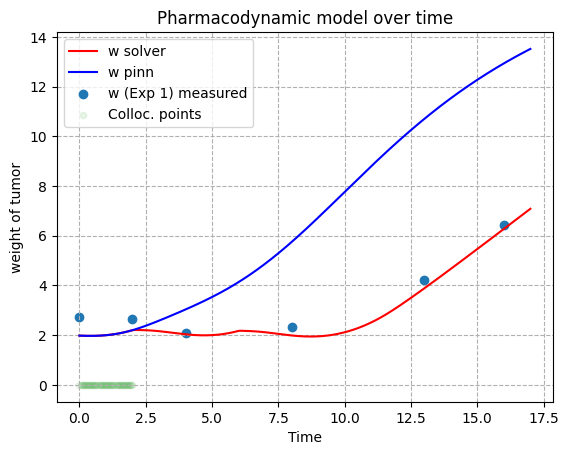

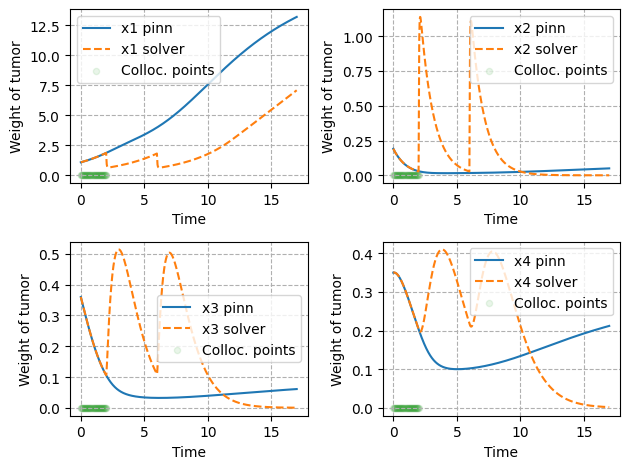

Interval 2: 2 to 6
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=2.80e-04, 	 loss_IC=2.80e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.20e+00,	 loss_e2=1.18e+00,	 loss_e3=1.23e-02,	 loss_e4=4.98e-02
Epoch=1000, 	 , 	 loss=2.16e+00, 	 loss_IC=3.30e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.08e+00,	 loss_e2=1.08e+00,	 loss_e3=2.47e-04,	 loss_e4=2.26e-03
Epoch=2000, 	 , 	 loss=2.14e+00, 	 loss_IC=5.20e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.07e+00,	 loss_e2=1.07e+00,	 loss_e3=1.19e-04,	 loss_e4=1.15e-03
Epoch=3000, 	 , 	 loss=2.15e+00, 	 loss_IC=3.62e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.07e+00,	 loss_e2=1.07e+00,	 loss_e3=2.60e-04,	 loss_e4=4.58e-04
Epoch=4000, 	 , 	 loss=2.07e+00, 	 loss_IC=2.21e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.04e+00,	 loss_e2=1.04e+00,	 loss_e3=2.69e-04,	 loss_e4=4.98e-04
Epoch=5000, 	 , 	 loss=1.99e+00, 	 loss_IC=2.52e-04, 	 loss_d=0.00e+00, 	 loss_e1=9.94e-01,	 loss_e2=9.95e-01,	 loss_e3=2.21e-04,	 loss_e4=4.25e-04
Epoch=

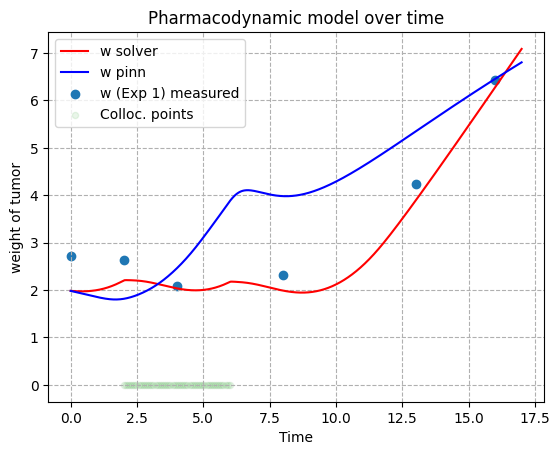

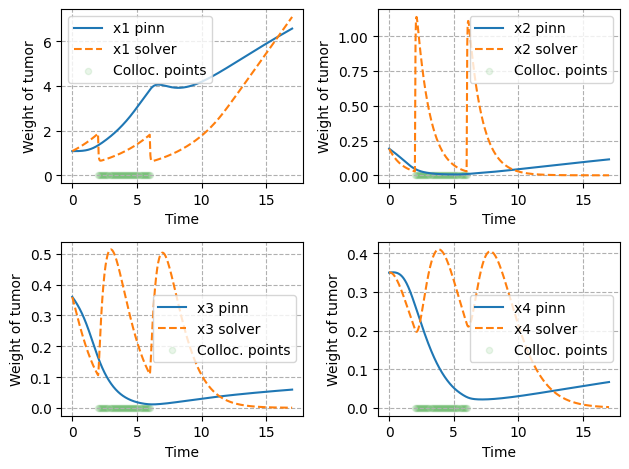

Interval 3: 6 to 10
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=5.19e-04, 	 loss_IC=5.19e-04, 	 loss_d=0.00e+00, 	 loss_e1=2.50e+00,	 loss_e2=2.42e+00,	 loss_e3=3.18e-03,	 loss_e4=6.14e-03
Epoch=1000, 	 , 	 loss=2.34e+00, 	 loss_IC=4.04e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.17e+00,	 loss_e2=1.17e+00,	 loss_e3=2.45e-03,	 loss_e4=1.08e-03
Epoch=2000, 	 , 	 loss=1.89e+00, 	 loss_IC=5.40e-04, 	 loss_d=0.00e+00, 	 loss_e1=9.46e-01,	 loss_e2=9.47e-01,	 loss_e3=8.99e-04,	 loss_e4=6.24e-04
Epoch=3000, 	 , 	 loss=1.61e+00, 	 loss_IC=2.58e-04, 	 loss_d=0.00e+00, 	 loss_e1=8.04e-01,	 loss_e2=8.05e-01,	 loss_e3=7.21e-04,	 loss_e4=4.37e-04
Epoch=4000, 	 , 	 loss=1.43e+00, 	 loss_IC=2.75e-04, 	 loss_d=0.00e+00, 	 loss_e1=7.13e-01,	 loss_e2=7.13e-01,	 loss_e3=5.19e-04,	 loss_e4=2.92e-04
Epoch=5000, 	 , 	 loss=1.28e+00, 	 loss_IC=2.80e-04, 	 loss_d=0.00e+00, 	 loss_e1=6.38e-01,	 loss_e2=6.38e-01,	 loss_e3=5.67e-04,	 loss_e4=2.75e-04
Epoch

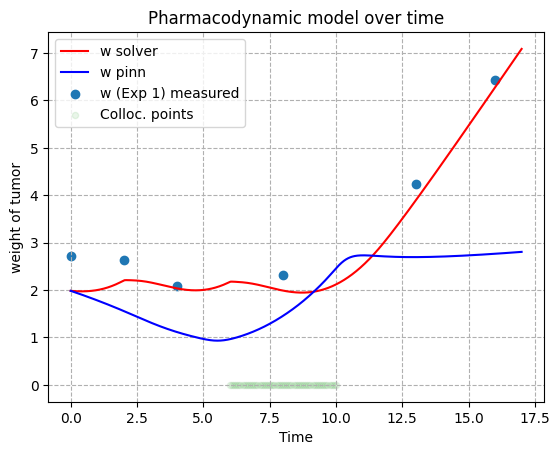

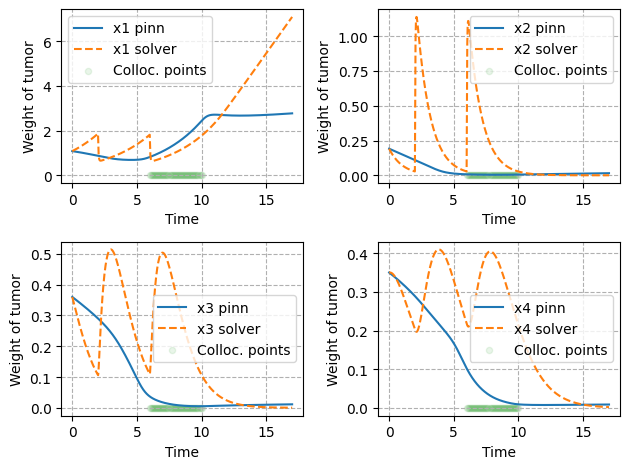

Interval 4: 10 to 17
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=2.90e-04, 	 loss_IC=2.90e-04, 	 loss_d=0.00e+00, 	 loss_e1=6.90e-01,	 loss_e2=1.18e-02,	 loss_e3=1.50e-03,	 loss_e4=1.41e-03
Epoch=1000, 	 , 	 loss=2.26e-02, 	 loss_IC=3.44e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.36e-02,	 loss_e2=5.46e-03,	 loss_e3=7.69e-04,	 loss_e4=2.34e-03
Epoch=2000, 	 , 	 loss=2.15e-02, 	 loss_IC=2.98e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.35e-02,	 loss_e2=6.44e-03,	 loss_e3=6.92e-04,	 loss_e4=6.40e-04
Epoch=3000, 	 , 	 loss=2.15e-02, 	 loss_IC=2.99e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.36e-02,	 loss_e2=6.57e-03,	 loss_e3=5.99e-04,	 loss_e4=3.78e-04
Epoch=4000, 	 , 	 loss=2.13e-02, 	 loss_IC=2.98e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.38e-02,	 loss_e2=6.43e-03,	 loss_e3=4.19e-04,	 loss_e4=3.20e-04
Epoch=5000, 	 , 	 loss=2.11e-02, 	 loss_IC=2.99e-04, 	 loss_d=0.00e+00, 	 loss_e1=1.39e-02,	 loss_e2=6.22e-03,	 loss_e3=2.99e-04,	 loss_e4=3.27e-04
Epoc

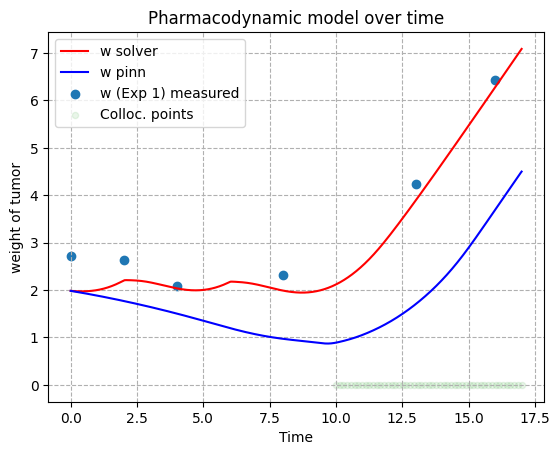

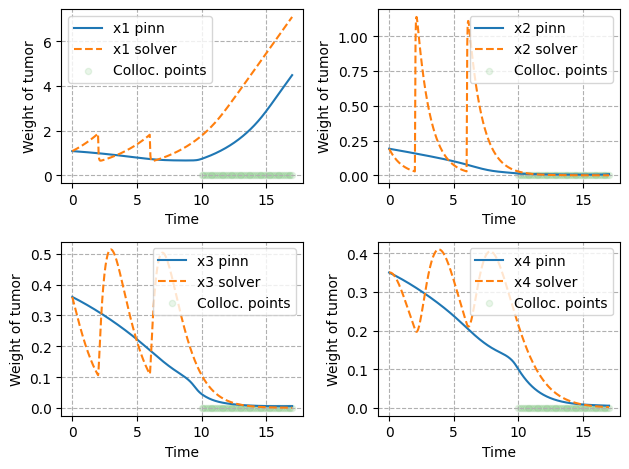

In [125]:


seed = 123#random.randint(1, 1000)
params = init_params([1] + [30]*6+[4], seed)
# params_extra = init_params([1] + [20]*4+[1],seed)  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)
#################################################################
num_seeds = 1

all_C1 = []
# all_C2 = []
# all_k = []
k2_values_list = []
k1_values_list = []
l1_values_list = []
l2_values_list = []

loss_his, loss_indi_his, epoch_his = [], [], []

time_points = np.array([0, 2, 6, 10, 17])
# time_points = np.array([0, 1.9, 2.1, 2.5, 5.9, 6.1, 6.5, 10, 17])

# start_time = time.time()

loss_weight_phase1 = [1, 1, 0, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]
iterations_per_interval = 10000
total_desired_points = 50

for i in range(1, len(time_points)):
    # Calculate number of points for this interval
    interval_length = time_points[i] - time_points[0]
    print(f"Interval {i}: {time_points[i-1]} to {time_points[i]}")
    print(f' Initial condition:   ti = {t_i} , f(ti) =  {IC}')
    t_c= jnp.linspace(time_points[i-1], time_points[i], total_desired_points+1)[:, None]
    tc = np.linspace(time_points[i-1], time_points[i], total_desired_points+1)[:, None]

    # start_time = time.time()
    epochs_phase1 = 0
    epochs_phase2 = iterations_per_interval

    for ep in range(epochs_phase1 + epochs_phase2 + 1):
        if ep <= epochs_phase1:
            loss_weight = loss_weight_phase1
        else:
            loss_weight = loss_weight_phase2

        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight)

        # print loss and epoch info
        if ep %(1000) ==0:
          loss_val = loss_fun_total(params, t_i, t_data, t_c, IC, data, loss_weight)
          loss_val_individual = loss_fun(params, t_i, t_data, t_c, IC, data)
          epoch_his.append(ep)
          loss_his.append(loss_val)
          loss_indi_his.append(loss_val_individual)

        if ep %(1000) ==0:
          print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e},\t loss_e3={loss_val_individual[4]:.2e},\t loss_e4={loss_val_individual[5]:.2e}')


    t_dense = np.linspace(0, 17, 1701)[:, None]
    pred = fwd(params,t_dense)
    # plt.scatter(t_data, data,alpha=0.3)


    w = y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
    C = denormalize(pred[:,[0]], y_dense[:,[0]]) + denormalize(pred[:,[1]], y_dense[:,[1]]) + denormalize(pred[:,[2]], y_dense[:,[2]])+ denormalize(pred[:,[3]], y_dense[:,[3]])
    plt.figure()
    # w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]
    plt.plot(t_dense, w, '-',color='red', label='w solver')
    plt.plot(t_dense, C, '-',color='blue', label='w pinn')
    plt.scatter(t_data, data, label='w (Exp 1) measured')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,
            label='Colloc. points')


    plt.title('Pharmacodynamic model over time')
    plt.xlabel('Time')
    plt.ylabel('weight of tumor')
    plt.legend()
    plt.grid(True,which="both", ls="--")
    plt.xscale('linear')
    # plt.grid(which="both")
    plt.show()

    # plt.figure(figsize=(10, 10))  # You can adjust the figure size to better fit your display

    # First subplot
    plt.subplot(2, 2, 1)
    plt.plot(t_dense, denormalize(pred[:,[0]], y_dense[:,[0]]), '-', label='x1 pinn')
    plt.plot(t_dense, y_dense[:, 0], '--', label='x1 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x1')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Second subplot
    plt.subplot(2, 2, 2)
    plt.plot(t_dense, denormalize(pred[:,[1]], y_dense[:,[1]]), '-', label='x2 pinn')
    plt.plot(t_dense, y_dense[:, 1], '--', label='x2 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x2')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Third subplot
    plt.subplot(2, 2, 3)
    plt.plot(t_dense, denormalize(pred[:,[2]], y_dense[:,[2]]), '-', label='x3 pinn')
    plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x3')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Fourth subplot
    plt.subplot(2, 2, 4)
    plt.plot(t_dense, denormalize(pred[:,[3]], y_dense[:,[3]]), '-', label='x4 pinn')
    plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x4')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area.
    plt.show()

    np.savez(f'./params_{sd}.npz', *params)



Interval 1: 0.0 to 2.0
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=4.15e-01, 	 loss_IC=4.15e-01, 	 loss_d=0.00e+00, 	 loss_e1=1.66e+00,	 loss_e2=1.69e+00,	 loss_e3=4.37e-01,	 loss_e4=8.86e-02
Epoch=1000, 	 , 	 loss=5.47e-01, 	 loss_IC=4.16e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.56e-01,	 loss_e2=2.34e-01,	 loss_e3=6.72e-04,	 loss_e4=1.49e-02
Epoch=2000, 	 , 	 loss=4.64e-01, 	 loss_IC=3.35e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.21e-01,	 loss_e2=2.05e-01,	 loss_e3=2.84e-04,	 loss_e4=4.19e-03
Epoch=3000, 	 , 	 loss=4.56e-01, 	 loss_IC=3.39e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.18e-01,	 loss_e2=2.04e-01,	 loss_e3=1.61e-04,	 loss_e4=8.66e-04
Epoch=4000, 	 , 	 loss=4.52e-01, 	 loss_IC=3.41e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.14e-01,	 loss_e2=2.03e-01,	 loss_e3=1.42e-04,	 loss_e4=6.80e-04
Epoch=5000, 	 , 	 loss=4.47e-01, 	 loss_IC=3.42e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.11e-01,	 loss_e2=2.02e-01,	 loss_e3=1.73e-04,	 loss_e4=4.46e-04
Ep

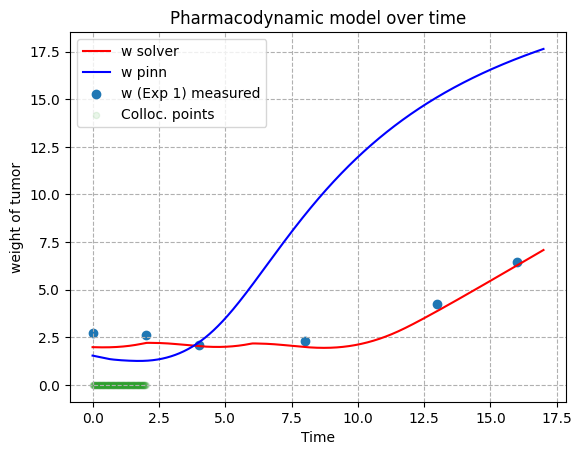

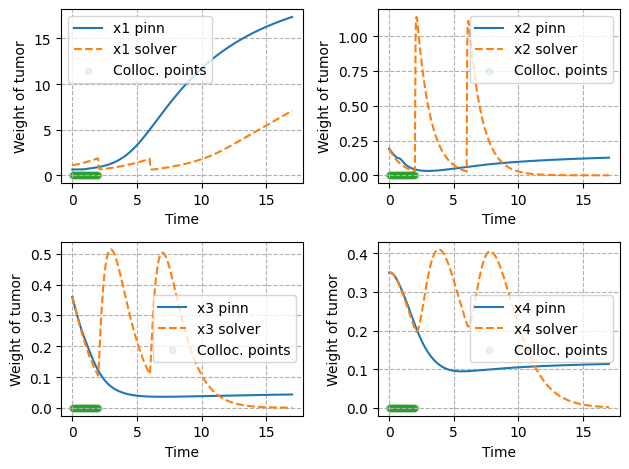

Interval 2: 0.0 to 2.5
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=3.45e-02, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.14e-01,	 loss_e2=2.03e-01,	 loss_e3=7.14e-04,	 loss_e4=2.98e-03
Epoch=1000, 	 , 	 loss=4.36e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.93e-01,	 loss_e3=1.73e-04,	 loss_e4=6.43e-04
Epoch=2000, 	 , 	 loss=4.32e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.89e-01,	 loss_e3=4.67e-04,	 loss_e4=3.27e-04
Epoch=3000, 	 , 	 loss=4.27e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.07e-01,	 loss_e2=1.84e-01,	 loss_e3=7.76e-04,	 loss_e4=3.24e-04
Epoch=4000, 	 , 	 loss=4.14e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.07e-01,	 loss_e2=1.72e-01,	 loss_e3=5.16e-04,	 loss_e4=3.44e-04
Epoch=5000, 	 , 	 loss=3.87e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.06e-01,	 loss_e2=1.45e-01,	 loss_e3=3.42e-04,	 loss_e4=6.32e-04
Ep

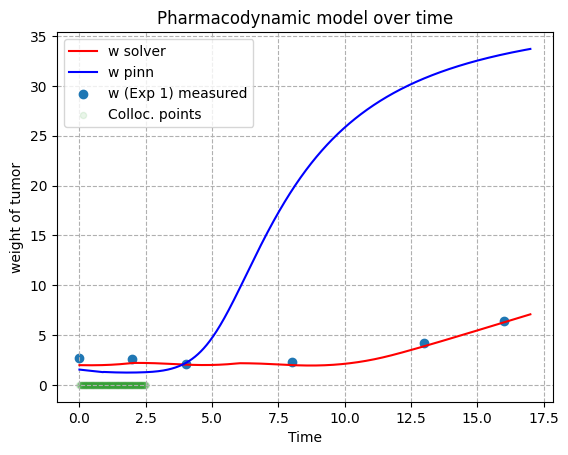

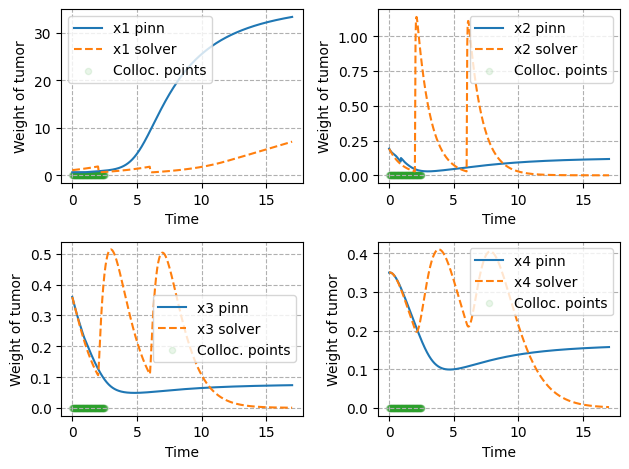

Interval 3: 0.0 to 6.0
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=3.45e-02, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=1.83e+00,	 loss_e2=2.46e-01,	 loss_e3=4.57e-03,	 loss_e4=3.19e-02
Epoch=1000, 	 , 	 loss=4.51e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.13e-01,	 loss_e2=2.01e-01,	 loss_e3=1.20e-03,	 loss_e4=1.25e-03
Epoch=2000, 	 , 	 loss=4.46e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.12e-01,	 loss_e2=1.98e-01,	 loss_e3=1.05e-03,	 loss_e4=4.81e-04
Epoch=3000, 	 , 	 loss=4.42e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.11e-01,	 loss_e2=1.96e-01,	 loss_e3=8.28e-04,	 loss_e4=3.80e-04
Epoch=4000, 	 , 	 loss=4.39e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.10e-01,	 loss_e2=1.94e-01,	 loss_e3=5.93e-04,	 loss_e4=3.28e-04
Epoch=5000, 	 , 	 loss=4.36e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.10e-01,	 loss_e2=1.91e-01,	 loss_e3=4.02e-04,	 loss_e4=2.49e-04
Ep

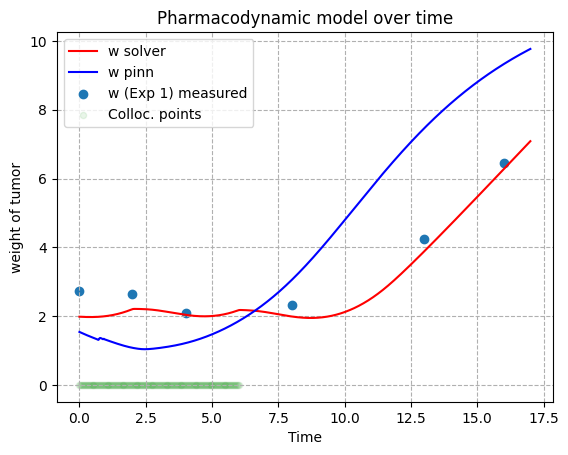

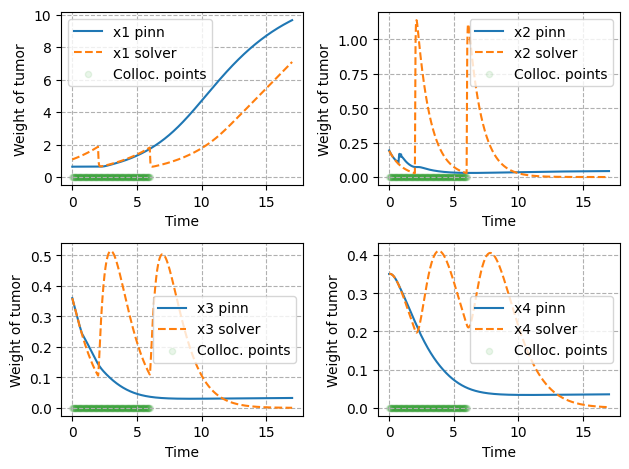

Interval 4: 0.0 to 6.5
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=3.45e-02, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.10e-01,	 loss_e2=2.31e-01,	 loss_e3=5.88e-04,	 loss_e4=1.30e-03
Epoch=1000, 	 , 	 loss=3.71e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.07e-01,	 loss_e2=1.29e-01,	 loss_e3=4.48e-04,	 loss_e4=7.82e-04
Epoch=2000, 	 , 	 loss=2.78e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.07e-01,	 loss_e2=3.44e-02,	 loss_e3=9.07e-04,	 loss_e4=8.01e-04
Epoch=3000, 	 , 	 loss=2.48e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.06e-01,	 loss_e2=6.31e-03,	 loss_e3=8.27e-04,	 loss_e4=5.08e-04
Epoch=4000, 	 , 	 loss=2.45e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.06e-01,	 loss_e2=3.23e-03,	 loss_e3=5.00e-04,	 loss_e4=4.30e-04
Epoch=5000, 	 , 	 loss=2.43e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.06e-01,	 loss_e2=2.26e-03,	 loss_e3=3.69e-04,	 loss_e4=3.57e-04
Ep

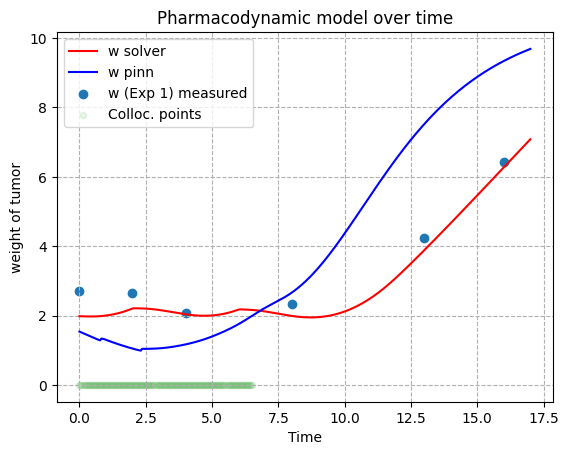

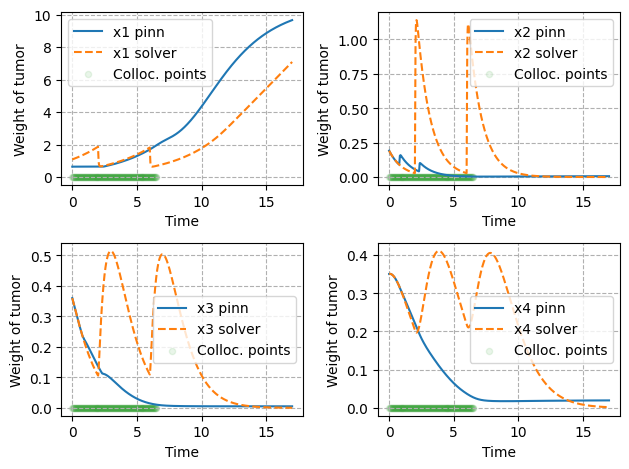

Interval 5: 0.0 to 10.0
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=3.45e-02, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.67e-01,	 loss_e2=2.61e-01,	 loss_e3=4.06e-03,	 loss_e4=5.96e-03
Epoch=1000, 	 , 	 loss=4.45e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.10e-01,	 loss_e2=1.97e-01,	 loss_e3=6.20e-04,	 loss_e4=2.19e-03
Epoch=2000, 	 , 	 loss=4.40e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.09e-01,	 loss_e2=1.95e-01,	 loss_e3=7.71e-04,	 loss_e4=8.07e-04
Epoch=3000, 	 , 	 loss=4.36e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.09e-01,	 loss_e2=1.92e-01,	 loss_e3=4.50e-04,	 loss_e4=4.01e-04
Epoch=4000, 	 , 	 loss=4.32e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.88e-01,	 loss_e3=4.23e-04,	 loss_e4=2.21e-04
Epoch=5000, 	 , 	 loss=4.23e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.79e-01,	 loss_e3=1.03e-03,	 loss_e4=4.75e-04
E

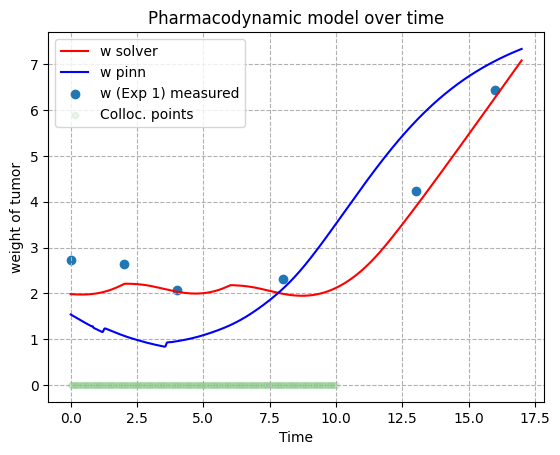

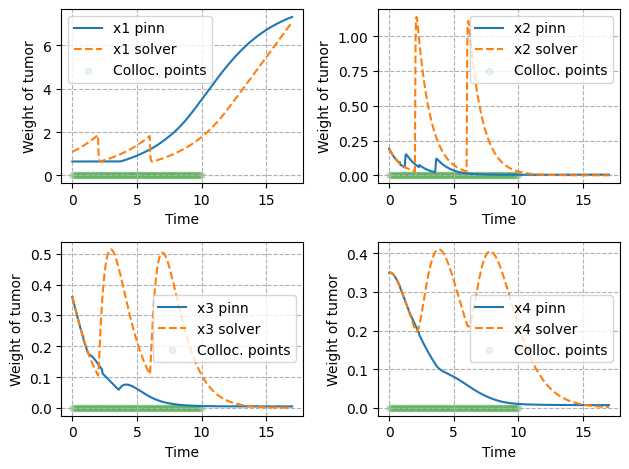

Interval 6: 0.0 to 17.0
 Initial condition:   ti = [[0]] , f(ti) =  [0.0689802  0.16771737 0.6994229  0.85285485]
Epoch=0, 	 , 	 loss=3.45e-02, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=3.76e-01,	 loss_e2=3.40e-01,	 loss_e3=8.63e-03,	 loss_e4=5.08e-03
Epoch=1000, 	 , 	 loss=4.46e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.11e-01,	 loss_e2=1.98e-01,	 loss_e3=6.46e-04,	 loss_e4=1.58e-03
Epoch=2000, 	 , 	 loss=4.40e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.09e-01,	 loss_e2=1.94e-01,	 loss_e3=1.03e-03,	 loss_e4=8.97e-04
Epoch=3000, 	 , 	 loss=4.34e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.09e-01,	 loss_e2=1.88e-01,	 loss_e3=1.19e-03,	 loss_e4=7.37e-04
Epoch=4000, 	 , 	 loss=4.30e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.86e-01,	 loss_e3=1.34e-03,	 loss_e4=7.93e-04
Epoch=5000, 	 , 	 loss=4.28e-01, 	 loss_IC=3.45e-02, 	 loss_d=0.00e+00, 	 loss_e1=2.08e-01,	 loss_e2=1.83e-01,	 loss_e3=1.36e-03,	 loss_e4=7.56e-04
E

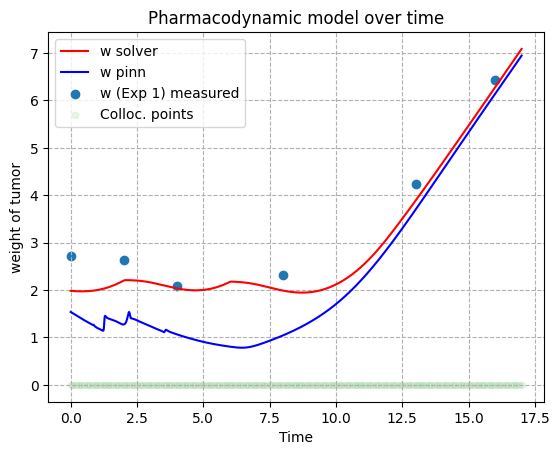

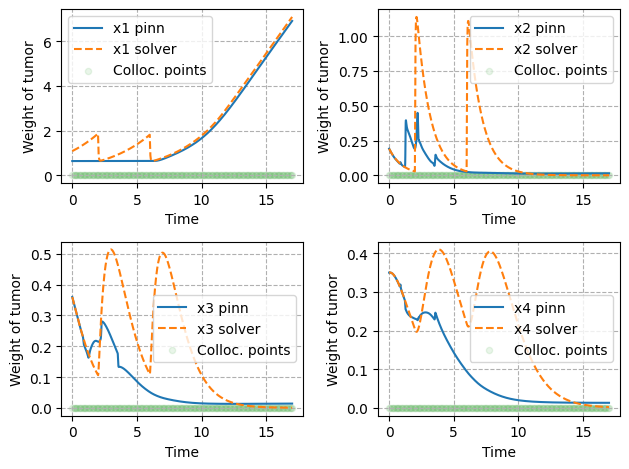

In [ ]:
################################################
def ODE_loss(t, y1, y2, y3, y4, y1_sol, y2_sol, y3_sol, y4_sol, params):
    psi = 20
    k1 = 0.968#==> True
    k2 = 6.29e-4 #==> True
    l0 =0.273 #0.311#*24 #==> True
    l1 = 0.814#0.656#*24 #==> True
    w0_exp1 = 0.055 #==> not true 0.055

    # # # k1 = get_variable(1, params[0]['k12'])
    # k1 = jnp.tanh(params[0]['k1']) * 0.6 + 1.0
    # k2 = (jnp.tanh(params[0]['k2']) * 5*1e-4 + 10*1e-4)
    # t_dose=np.arange(13,22,4)

    # t_dose=np.arange(13,22,4)
    t_dose=np.arange(2,7,4)
    # tc = np.linspace(0, 17, 171)[:, None]
    A = 29975901.2365281
    B = 24098.7619595
    kA = 20.9912588
    kB = 1.9959407

    Qm = np.sum([
    A * np.exp(-kA * (tc - t_d))*np.heaviside(tc - t_d, 0.001) + B * np.exp(-kB * (tc - t_d))*np.heaviside(tc - t_d, 0.001)
    for t_d in t_dose
    ], axis=0)
    c = Qm/V1
    c= jnp.array(c)
    # # # # c=0
    # A1 = simulate_system()
    # t_dense = jnp.linspace(0, 35, 3501)
    # c = jnp.interp(t, t_dense, A1)/V1
    # c = c.reshape(-1,1)


    y_1= denormalize(y1(t),y_dense[:,[0]])
    y_2= denormalize(y2(t),y_dense[:,[1]])
    y_3= denormalize(y3(t),y_dense[:,[2]])
    y_4= denormalize(y4(t),y_dense[:,[3]])

    # y_1s= y1_sol(t) *scale_factor[0]
    # y_2s= y2_sol(t) *scale_factor[1]
    # y_3s= y3_sol(t) *scale_factor[2]
    # y_4s= y4_sol(t) *scale_factor[3]

    # y_4= y4(jnp.reshape(t, (-1, 1))) *scale_factor[3]

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    y4_t = lambda t: jax.grad(lambda t: jnp.sum(y4(t)))(t)


    x1, x2, x3, x4 = y_1, y_2, y_3, y_4
    w = x1 + x2 + x3 + x4

    x1_scale= jnp.max(y_dense[:,[0]]) - (jnp.min(y_dense[:,[0]]))
    x2_scale= jnp.max(y_dense[:,[1]]) - (jnp.min(y_dense[:,[1]]))
    x3_scale= jnp.max(y_dense[:,[2]]) - (jnp.min(y_dense[:,[2]]))
    x4_scale= jnp.max(y_dense[:,[3]]) - (jnp.min(y_dense[:,[3]]))


    # ode1 = y1_t(t) - 1/scale_factor[0]*((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    # ode2 = y2_t(t) - 1/scale_factor[1]*((k2 *c* x1 - k1 * x2))
    # ode3 = y3_t(t) - 1/scale_factor[2]*((k1 * (x2 - x3)))
    # ode4 = y4_t(t) - 1/scale_factor[3]*((k1 * (x3 - x4)))


    ode1 = x1_scale * y1_t(t) - ((l0 * x1 * (1 + (l0 / l1 * w)**(psi))** (-1/psi) - k2 *c* x1))
    ode2 = x2_scale * y2_t(t) - ((k2 *c* x1 - k1 * x2))
    ode3 = x3_scale * y3_t(t) - ((k1 * (x2 - x3)))
    ode4 = x4_scale * y4_t(t) - ((k1 * (x3 - x4)))

    return ode1, ode2, ode3, ode4




#collocation points
# N_c = 350

# t_c = jnp.linspace(0, 17, 171)[:, None]

# def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):
def loss_fun(params, t_i, t_d, t_c, data_IC, data):

    # l3, l4 = 1, 1
    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    y4_func = lambda t: fwd(params, t)[:, [3]]
    # ft      = lambda t: fwd(params, t)[:, [4]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    # y2_func = interp1d(t_dense.flatten(), y_dense[:, 1], kind='linear', fill_value='extrapolate')
    # y3_func = interp1d(t_dense.flatten(), y_dense[:, 2], kind='linear', fill_value='extrapolate')
    # y4_func = interp1d(t_dense.flatten(), y_dense[:, 3], kind='linear', fill_value='extrapolate')
    # t_dense = np.linspace(0, 35, 3501)
    y1_func_sol = lambda t:jax_interp(t, y_dense[:, 0])
    y2_func_sol = lambda t:jax_interp(t, y_dense[:, 1])
    y3_func_sol = lambda t:jax_interp(t, y_dense[:, 2])
    y4_func_sol = lambda t:jax_interp(t, y_dense[:, 3])

    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    # loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func, y4_func,params)
    loss_y1, loss_y2, loss_y3, loss_y4 = ODE_loss(t_c, y1_func, y2_func, y3_func,y4_func,y1_func_sol, y2_func_sol, y3_func_sol, y4_func_sol, params)

    # loss_y1 = l1*loss_y1
    # loss_y2 = l2*loss_y2
    # loss_y3 = l3*loss_y3
    # loss_y4 = l4*loss_y4

    loss_y1 = loss_y1
    loss_y2 = loss_y2
    loss_y3 = loss_y3
    loss_y4 = loss_y4

    # loss_ode1 = jnp.mean(loss_y1 ** 2)
    # loss_ode2 = jnp.mean(loss_y2 ** 2)
    # loss_ode3 = jnp.mean(loss_y3 ** 2)
    # loss_ode4 = jnp.mean(loss_y4 ** 2)


    loss_ode1 = jnp.sqrt(jnp.mean((loss_y1) ** 2))#/jnp.max(loss_y1)
    loss_ode2 = jnp.sqrt(jnp.mean((loss_y2) ** 2))#/jnp.max(loss_y2)
    loss_ode3 = jnp.sqrt(jnp.mean((loss_y3) ** 2))#/jnp.max(loss_y3)
    loss_ode4 = jnp.sqrt(jnp.mean((loss_y4) ** 2))#/jnp.max(loss_y4)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    # i= np.array([0]).reshape(-1,1)
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i),y3_func(t_i), y4_func(t_i)],axis=1)
    # loss_IC = MSE(data_IC, pred_IC)
    loss_IC = L2_error(data_IC, pred_IC)



    # t_d    = t_d.flatten()[:,None]
    # w = denormalize(y1_func(t_d), y_dense[:,[0]]) + denormalize(y2_func(t_d), y_dense[:,[1]]) + denormalize(y3_func(t_d), y_dense[:,[2]])+ denormalize(y4_func(t_d), y_dense[:,[3]])
    # data = data.reshape(-1, 1)
    # # pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    # loss_data = MSE(data, w)
    loss_data = 0



    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4





# def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

#     return loss_total


def loss_fun_total(params, t_i, t_d, t_c, data_IC, data, loss_weight):

    # loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)
    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4 = loss_fun(params, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2+ loss_weight[4]*loss_ode3+ loss_weight[5]*loss_ode4

    return loss_total


@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0])(params, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state, params



# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

#   #Update params
#   updates, opt_state = optimizer.update(grads[0], opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
#   params_l1 = optax.apply_updates(params_l1, updates_l1)

#   updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
#   params_l2 = optax.apply_updates(params_l2, updates_l2)


#   return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2





seed = 123#random.randint(1, 1000)
params = init_params([1] + [30]*6+[4], seed)
# params_extra = init_params([1] + [20]*4+[1],seed)  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)
#################################################################
num_seeds = 1

all_C1 = []
# all_C2 = []
# all_k = []
k2_values_list = []
k1_values_list = []
l1_values_list = []
l2_values_list = []

loss_his, loss_indi_his, epoch_his = [], [], []

time_points = np.array([0, 2, 2.5, 6, 6.5, 10, 17])

# start_time = time.time()

loss_weight_phase1 = [1, 1, 0, 0, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]
iterations_per_interval = 10000
total_desired_points = 170

for i in range(1, len(time_points)):
    # Calculate number of points for this interval
    interval_length = time_points[i] - time_points[0]
    print(f"Interval {i}: {time_points[0]} to {time_points[i]}")
    print(f' Initial condition:   ti = {t_i} , f(ti) =  {IC}')
    t_c= jnp.linspace(time_points[0], time_points[i], total_desired_points+1)[:, None]

    # start_time = time.time()
    epochs_phase1 = 0
    epochs_phase2 = iterations_per_interval

    for ep in range(epochs_phase1 + epochs_phase2 + 1):
        if ep <= epochs_phase1:
            loss_weight = loss_weight_phase1
        else:
            loss_weight = loss_weight_phase2

        opt_state, params = update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight)

        # print loss and epoch info
        if ep %(1000) ==0:
          loss_val = loss_fun_total(params, t_i, t_data, t_c, IC, data, loss_weight)
          loss_val_individual = loss_fun(params, t_i, t_data, t_c, IC, data)
          epoch_his.append(ep)
          loss_his.append(loss_val)
          loss_indi_his.append(loss_val_individual)

        if ep %(1000) ==0:
          print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e},\t loss_e3={loss_val_individual[4]:.2e},\t loss_e4={loss_val_individual[5]:.2e}')


    t_dense = np.linspace(0, 17, 1701)[:, None]
    pred = fwd(params,t_dense)
    # plt.scatter(t_data, data,alpha=0.3)


    w = y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
    C = denormalize(pred[:,[0]], y_dense[:,[0]]) + denormalize(pred[:,[1]], y_dense[:,[1]]) + denormalize(pred[:,[2]], y_dense[:,[2]])+ denormalize(pred[:,[3]], y_dense[:,[3]])
    plt.figure()
    # w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]
    plt.plot(t_dense, w, '-',color='red', label='w solver')
    plt.plot(t_dense, C, '-',color='blue', label='w pinn')
    plt.scatter(t_data, data, label='w (Exp 1) measured')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,
            label='Colloc. points')


    plt.title('Pharmacodynamic model over time')
    plt.xlabel('Time')
    plt.ylabel('weight of tumor')
    plt.legend()
    plt.grid(True,which="both", ls="--")
    plt.xscale('linear')
    # plt.grid(which="both")
    plt.show()

    # plt.figure(figsize=(10, 10))  # You can adjust the figure size to better fit your display

    # First subplot
    plt.subplot(2, 2, 1)
    plt.plot(t_dense, denormalize(pred[:,[0]], y_dense[:,[0]]), '-', label='x1 pinn')
    plt.plot(t_dense, y_dense[:, 0], '--', label='x1 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x1')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Second subplot
    plt.subplot(2, 2, 2)
    plt.plot(t_dense, denormalize(pred[:,[1]], y_dense[:,[1]]), '-', label='x2 pinn')
    plt.plot(t_dense, y_dense[:, 1], '--', label='x2 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x2')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Third subplot
    plt.subplot(2, 2, 3)
    plt.plot(t_dense, denormalize(pred[:,[2]], y_dense[:,[2]]), '-', label='x3 pinn')
    plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x3')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    # Fourth subplot
    plt.subplot(2, 2, 4)
    plt.plot(t_dense, denormalize(pred[:,[3]], y_dense[:,[3]]), '-', label='x4 pinn')
    plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
    plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1,label='Colloc. points')

    # plt.title('Pharmacodynamic model over time - x4')
    plt.xlabel('Time')
    plt.ylabel('Weight of tumor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xscale('linear')

    plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area.
    plt.show()

    np.savez(f'./params_{sd}.npz', *params)



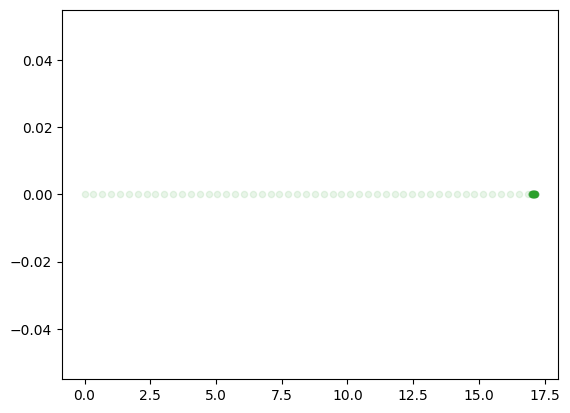

In [122]:
t_c1= jnp.linspace(time_points[0], time_points[i]-0.15, total_desired_points+1)[:, None]
t_c2= jnp.linspace(time_points[i]+0.15, time_points[i], total_desired_points+1)[:, None]

# Concatenate t_c1 and t_c2
t_c = jnp.concatenate((t_c1, t_c2), axis=0)
plt.scatter(t_c, -0 * jnp.ones_like(t_c), s=20, color="tab:green", alpha=0.1)


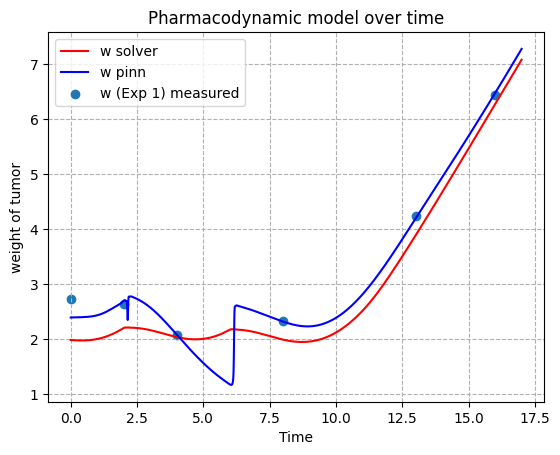

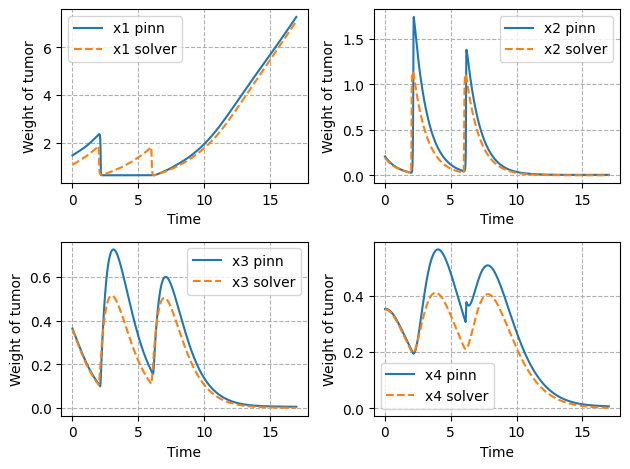

In [104]:
#@title forward with data
t_dense = np.linspace(0, 17, 1701)[:, None]
pred = fwd(params,t_dense)

# C = pred[:,0]*scale_factor[0]+y_dense[:,1]*scale_factor[1]+ y_dense[:,2]*scale_factor[2]+y_dense[:,3]*scale_factor[3]
w = y_dense[:,0]+y_dense[:,1]+ y_dense[:,2]+y_dense[:,3]
C = denormalize(pred[:,[0]], y_dense[:,[0]]) + denormalize(pred[:,[1]], y_dense[:,[1]]) + denormalize(pred[:,[2]], y_dense[:,[2]])+ denormalize(pred[:,[3]], y_dense[:,[3]])
plt.figure()
# w = y_dense[:, 0] + y_dense[:, 1]+ y_dense[:, 2]+ y_dense[:, 3]
plt.plot(t_dense, w, '-',color='red', label='w solver')
plt.plot(t_dense, C, '-',color='blue', label='w pinn')
plt.scatter(t_data, data, label='w (Exp 1) measured')


plt.title('Pharmacodynamic model over time')
plt.xlabel('Time')
plt.ylabel('weight of tumor')
plt.legend()
plt.grid(True,which="both", ls="--")
plt.xscale('linear')
# plt.grid(which="both")
plt.show()





# Assuming 'pred', 'y_dense', and 'scale_factor' are defined
t_dense = np.linspace(0, 17, 1701)[:, None]

# plt.figure(figsize=(10, 10))  # You can adjust the figure size to better fit your display

# First subplot
plt.subplot(2, 2, 1)
plt.plot(t_dense, denormalize(pred[:,[0]], y_dense[:,[0]]), '-', label='x1 pinn')
plt.plot(t_dense, y_dense[:, 0], '--', label='x1 solver')
# plt.title('Pharmacodynamic model over time - x1')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Second subplot
plt.subplot(2, 2, 2)
plt.plot(t_dense, denormalize(pred[:,[1]], y_dense[:,[1]]), '-', label='x2 pinn')
plt.plot(t_dense, y_dense[:, 1], '--', label='x2 solver')
# plt.title('Pharmacodynamic model over time - x2')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Third subplot
plt.subplot(2, 2, 3)
plt.plot(t_dense, denormalize(pred[:,[2]], y_dense[:,[2]]), '-', label='x3 pinn')
plt.plot(t_dense, y_dense[:, 2], '--', label='x3 solver')
# plt.title('Pharmacodynamic model over time - x3')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

# Fourth subplot
plt.subplot(2, 2, 4)
plt.plot(t_dense, denormalize(pred[:,[3]], y_dense[:,[3]]), '-', label='x4 pinn')
plt.plot(t_dense, y_dense[:, 3], '--', label='x4 solver')
# plt.title('Pharmacodynamic model over time - x4')
plt.xlabel('Time')
plt.ylabel('Weight of tumor')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xscale('linear')

plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()
